# Imports

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_directml
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import scipy
from scipy.stats import zscore
from time import sleep
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, log_loss
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import math
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # TODO: Actually optimize the source of this warning
simplefilter(action='ignore', category=FutureWarning)
simplefilter("ignore", UserWarning)

# Pytorch Model

In [125]:
device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [130]:
CR_TO_IDX = {
    0: 0, 0.125: 1, 0.25: 2, 0.5: 3,
    1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 13,
    11: 14, 12: 15, 13: 16, 14: 17, 15: 18, 16: 19, 17: 20, 18: 21,
    19: 22, 20: 23, 21: 24, 22: 25, 23: 26, 24: 27, 25: 28, 26: 29,
    27: 30, 28: 31, 29: 32, 30: 33
}

IDX_TO_CR = {
    0: 0, 1: 0.125, 2: 0.25, 3: 0.5, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 
    10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14, 18: 15, 
    19: 16, 20: 17, 21: 18, 22: 19, 23: 20, 24: 21, 25: 22, 26: 23, 27: 24, 
    28: 25, 29: 26, 30: 27, 31: 28, 32: 29, 33: 30
}
crs = [
    0, 0.125, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
    24, 25, 26, 27, 28, 29, 30
]
indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
    15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
    28, 29, 30, 31, 32, 33
]

class MonsterDataset(Dataset):
    def __init__(self, csv_file, train, train_val=.9, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            train (boolean): Whether this dataset is being used for training or testing
            train_val (float): Percentage of data to be used in training (the rest will be used in testing)
            transform: Literally not used here
        """
        self.CAT_COLS = ['size','alignment','type','legendary']
        self.NONNUMERIC_COLS = ['size','alignment','type','legendary','name','attributes','actions','legendary_actions']
        self.__parsecsv__(csv_file)
        # Shuffle the data around so we don't get any bias in the order that they are listed
        self.df = self.df.sample(frac=1,random_state=796).reset_index(drop=True)

        if train:
            self.df = self.df.iloc[1:int(self.df.shape[0]*train_val)+1].reset_index(drop=True)
        else:
            self.df = self.df.iloc[int(self.df.shape[0]*train_val):self.df.shape[0]].reset_index(drop=True)

        # Create sub dfs of categorized data
        df_size = self.create_subdf("size")
        df_type = self.create_subdf("type")
        df_align = self.create_subdf("alignment")
        df_legend = self.create_subdf("legendary")
        df_attrs = self.create_subdf("attributes")
        df_actions = self.create_subdf("actions")

        cols_to_drop = list(df_size.columns) + list(df_type.columns) + \
                       list(df_align.columns) + list(df_legend.columns) + \
                       list(df_attrs.columns) + list(df_actions.columns) + \
                       ['name', 'cr']
        # Only drop columns that actually exist to avoid errors
        cols_to_drop = [c for c in cols_to_drop if c in self.df.columns]
        df_numeric = self.df.drop(cols_to_drop, axis=1)

        # Convert everything to Tensors
        # .values converts pandas to numpy, which creates tensors much faster
        self.names = self.df['name'].values

        self.data_size = torch.tensor(df_size.values, dtype=torch.long)
        self.data_type = torch.tensor(df_type.values, dtype=torch.long)
        self.data_align = torch.tensor(df_align.values, dtype=torch.long)
        self.data_legend = torch.tensor(df_legend.values, dtype=torch.long)
        self.data_attrs = torch.tensor(df_attrs.values, dtype=torch.long)
        self.data_actions = torch.tensor(df_actions.values, dtype=torch.long)

        # Pre-calculate targets
        self.data_numeric = torch.tensor(df_numeric.values, dtype=torch.float32)# Map the CR values to indices using a list comprehension or map
        targets = self.df['cr'].map(CR_TO_IDX).fillna(0).values 
        self.data_targets = torch.tensor(targets, dtype=torch.long)

        self.transform = transform

    def containsnan(self,df):
        for each in df:
            if df[each].isnull().values.any():
                return True
        return False
    
    def __parsecsv__(self, csv_file):
        self.df_original = pd.read_csv(csv_file)
        self.df = self.df_original.copy()
        self.original_categorical_vals = pd.DataFrame()

        self.__reclassify_categorical__('size')
        self.__reclassify_categorical__('alignment')
        self.__reclassify_categorical__('type')
        self.__reclassify_categorical__('legendary')
        self.__reclassify_list__('languages', ", ")
        self.__reclassify_list__('senses', ", ")
        self.__reclassify_attrs__()
        self.__reclassify_actions__()
        self.__reclassify_legendactions__()

        # # temporary removing of string values so I can work only on num values
        # self.df = self.df.drop(['legendary_actions'],axis=1)
        # remove source because these don't contribute anything
        self.df = self.df.drop(['source'],axis=1)
        
        self.__redefine_datatypes__()

        for col in self.CAT_COLS:
            self.dummify_cat_values(col)
        
    def dummify_cat_values(self, col):
        df_copy = self.df.copy()
        if col != 'alignment':
            dummies = pd.get_dummies(df_copy[col],prefix=col).astype('float32')
            df_copy = pd.concat([df_copy,dummies],axis=1)
        else:
            alignments = df_copy[col].str.split(",").tolist()
            flat_align = [col+"_"+item for sublist in alignments for item in sublist]
            set_align = set(flat_align)
            unique_align = list(set_align)
            df_copy = df_copy.reindex(df_copy.columns.tolist() + unique_align, axis=1, fill_value=0)
            # for each value inside column, update the dummy
            for i, row in df_copy.iterrows():
                for val in row[col].split(","):
                    tag = col+"_"+val
                    df_copy.loc[i,tag] = 1
            df_copy = df_copy.drop([col+"_unaligned"],axis=1)
        df_copy = df_copy.drop([col],axis=1)
        self.df = df_copy
    
    def __update_ocv__(self, df, col, unique):
        self.original_categorical_vals = pd.concat([self.original_categorical_vals, pd.DataFrame({col:unique})], axis=1)

    def __redefine_datatypes__(self):
        df_copy = self.df.copy()
        for each in df_copy.columns:
            if each in self.CAT_COLS:
                df_copy[each] = df_copy[each].astype('category')
            elif each == 'name':
                pass
            else:
                df_copy[each] = pd.to_numeric(df_copy[each], errors='coerce').astype(np.float32)
        self.df = df_copy
    
    def __reclassify_categorical__(self, col):
        df_copy = self.df.copy()
        if col == 'type':
            for i,each in enumerate(df_copy[col]):
                if "(" in each:
                    df_copy.at[i,col] = each[:(each.find("(")-1)]
        elif col == 'alignment':
            for i,each in enumerate(df_copy[col]):
                if each not in "lawful good,neutral good,chaotic good,lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil":
                    val = "unaligned"
                    if "any" in each:
                        if "non" in each:
                            if "-good" in each:
                                val = "lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil"
                            elif "-lawful" in each:
                                val = "neutral good,chaotic good,neutral,chaotic neutral,neutral evil,chaotic evil"
                        elif "evil" in each:
                            val = "lawful evil,neutral evil,chaotic evil"
                        elif "chaotic" in each:
                            val = "chaotic good,chaotic neutral,chaotic evil"
                        else:
                            val = "lawful good,neutral good,chaotic good,lawful neutral,neutral,chaotic neutral,lawful evil,neutral evil,chaotic evil"
                    elif "or" in each:
                        if "neutral good" in each and "neutral evil" in each:
                            val = "neutral good,neutral evil"
                        elif "chaotic good" in each and "neutral evil" in each:
                            val = "chaotic good,neutral evil"
                    df_copy.at[i,col] = val

        unique = df_copy[col].unique()
        self.__update_ocv__(df_copy, col, unique)
        self.df = df_copy
    
    def __reclassify_list__(self, col, delimiter):
        df_copy = self.df.copy()
        column = df_copy[col]
        for i in range(0,len(column)):
            num = 0
            item = column[i]
            vals = item.split(delimiter)
            for each in vals:
                each = each.lower()
                if "two" in each: num = num + 2
                elif "three" in each: num = num + 3
                elif "four" in each: num = num + 4
                elif "five" in each: num = num + 5
                else: num = num + 1
            df_copy.at[i,col] = num
        self.df = df_copy
    
    def __reclassify_attrs__(self):
        df_copy = self.df.copy()
        col = 'attributes'
        df_copy[col] = df_copy[col].fillna("unavailable")
        column = df_copy[col]
        attributes_list = [
            "amphibious",
            "spellcasting",
            "legendary resistance",
            "magic weapons",
            "false appearance",
            "magic resistance",
            "charge",
            "pack tactics",
            "sunlight sensitivity",
            "invisibility",
        ]
        keen_list = [
            "smell",
            "hearing",
            "sight",
        ]

        for i,attributes in enumerate(column):
            for attribute in attributes.split("|"):
                df_copy.at[i,'spellcaster_level'] = int(attributes[attributes.find("-level spellcaster")-4]+attributes[attributes.find("-level spellcaster")-3]) if "-level spellcaster" in attributes else 0
                for each in attributes_list:
                    df_copy.at[i,col+"_"+each.replace(" ","_")] = 1 if each in attributes.lower() else 0
                for each in keen_list:
                    df_copy.at[i,col+"_keen_"+each] = 1 if "keen" in attributes.lower() and each in attributes.lower() else 0
        
        self.df = df_copy

    def __reclassify_actions__(self):
        df_copy = self.df.copy()
        col = 'actions'
        df_copy[col] = df_copy[col].fillna("unavailable")
        column = df_copy[col]
        actions_list = [
            "frightful presence",
            "change shape",
            "teleport"
        ]
        
        for i,actions in enumerate(column):
            for action in actions.split("|"):
                item = action.split(".")[0].split("(")[0].lower().strip()
                colcheck = item.replace(" ","")
                if colcheck == "multiattack":
                    if "five" in action: df_copy.at[i,"multiattacks"] = 5
                    elif "four" in action: df_copy.at[i,"multiattacks"] = 4
                    elif "three" in action: df_copy.at[i,"multiattacks"] = 3
                    elif "two" in action: df_copy.at[i,"multiattacks"] = 2
                elif "damage" in action and "Hit:" in action:
                    flag = True
                    start = 0
                    dmg = action[action.find("Hit:")+5]+action[action.find("Hit:")+6]
                    if dmg.isnumeric():
                        dmg = int(dmg)
                    else:
                        dmg = 0
                    
                    while flag:
                        a = action.find("damage plus", start)  # find() returns -1 if the word is not found, 
                        #start i the starting index from the search starts(default value is 0)
                        if a == -1:         # if pattern not found set flag to False
                            flag = False
                        else:               # if word is found increase count and set starting index to a+1
                            dmg += int(action[action.find("damage plus")+12]+action[action.find("damage plus")+13])
                            start = a + 1
                    if ("damage" not in df_copy.columns):
                        df_copy.at[i,"damage"] = dmg
                    elif (not math.isnan(df_copy['damage'][i])):
                        df_copy.at[i,"damage"] = max(df_copy['damage'][i],dmg)
                    else:
                        df_copy.at[i,"damage"] = dmg
                
                for each in actions_list:
                    df_copy.at[i,col+"_"+each.replace(" ","_")] = 1 if each in actions.lower() else 0
        df_copy["damage"] = df_copy["damage"].fillna(0)
        df_copy["multiattacks"] = df_copy["multiattacks"].fillna(1)

        self.df = df_copy
    
    def __reclassify_legendactions__(self):
        df_copy = self.df.copy()
        col = 'legendary_actions'
        df_copy[col] = df_copy[col].fillna("unavailable")
        column = df_copy[col]

        for i,legendactions in enumerate(column):
            for j,legendaction in enumerate(legendactions.split("|")):
                item = legendaction.split(".")[0].split("(")[0].lower().strip()
                colcheck = item.replace(" ","")
                valid = not (colcheck == "unavailable" or colcheck == "none")
                if j == 0:
                    df_copy.at[i,"legend_action_count"] = int(legendaction[legendaction.find("legendary actions")-2]) if valid else 0
                    # df_copy.at[i,"legend_action_count"] = legendaction[:legendaction.find("legendary actions")]

        # display(df_copy['legend_action_count'])
        self.df = df_copy
    
    def __len__(self):
        return len(self.df)
    
    def getocv(self):
        return self.original_categorical_vals
    

    def create_subdf(self,substring):
        '''
        Isolates a whole section of the dataframe by creating a copy
        of it and concatenating columns containing the desired substring.
        Meant for creating sub-dataframes of categorized one-hot encoded data.
        '''
        df_copy = self.df.copy()
        subdf = pd.DataFrame()
        for each in df_copy:
            if each.find(substring) == 0:
                subdf = pd.concat([subdf,df_copy[each]],axis=1)
        subdf = subdf.fillna(0)
        return subdf
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (
            self.names[idx],
            self.data_numeric[idx],
            self.data_size[idx],
            self.data_type[idx],
            self.data_align[idx],
            self.data_legend[idx],
            self.data_attrs[idx],
            self.data_actions[idx],
            self.data_targets[idx]
        )
    
    def getdf(self):
        return self.df
    
    def getdf_original(self):
        return self.df_original

# Hyperparameters
input_size = 98 # not sure why this is 96; it's definitely NOT the dataframe column length
hidden_size = 100 # number of nodes in hidden layer
num_classes = 34 # number of classes, 0, 1/8, 1/4, 1/2, 1-30
num_epochs = 100 # number of times we go through the entire dataset
batch_size = 32 # number of samples in one forward/backward pass
learning_rate = 0.001 # learning rate
train_val = .8

# Datasets and Dataloaders
train_dataset = MonsterDataset("aidedd_blocks2.csv",train=True,train_val=train_val)
test_dataset = MonsterDataset("aidedd_blocks2.csv",train=False,train_val=train_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# train_df = train_dataset.getdf_original()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(train_df[train_df['cr']==30][['name','cr','senses','attributes','actions','legendary_actions','legendary']])

In [127]:
# ReLU seems bad.
# Tanh seems okay.
# Sigmoid seems best.

class CRPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CRPredictor,self).__init__()
        weight1 = 1.5
        weight2 = 2
        weight3 = 4
        
        self.l1 = nn.Linear(input_size,int(hidden_size*weight1)) # first layer
        self.act1 = nn.Sigmoid() # activation function
        self.l2 = nn.Linear(int(hidden_size*weight1),int(hidden_size*weight2)) # second layer
        self.act2 = nn.Sigmoid() # activation function
        self.l3 = nn.Linear(int(hidden_size*weight2),int(hidden_size*weight3)) # third layer
        self.act3 = nn.Sigmoid() # activation function
        self.l4 = nn.Linear(int(hidden_size*weight3),num_classes) # fourth layer
    
    def forward(self, numeric, cat1,cat2,cat3,cat4,cat5,cat6):
        x = torch.cat([numeric, cat1,cat2,cat3,cat4,cat5,cat6],dim=1)
        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        x = self.act3(x)
        x = self.l4(x)
        return x

model = CRPredictor(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training: 100%|##########| 100/100 [00:31<00:00,  3.14epochs/s, step=20/20, loss=0.03415]


Finished training.


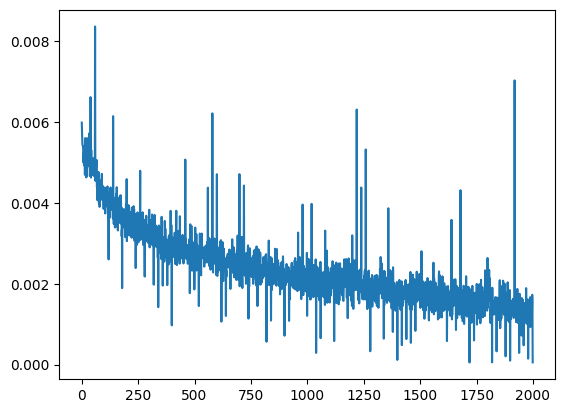

In [128]:
model.train()
n_total_steps = len(train_loader)
loss_values = []
i = 0
loss = 0
pbar = tqdm(range(num_epochs),desc="Training",unit="epochs",postfix={"loss":loss},colour="green",ascii=True)
for epoch in pbar:
    running_loss = 0.0
    for i, (name,numeric,cat1,cat2,cat3,cat4,cat5,cat6,target) in enumerate(train_loader):
        
        # --- CRITICAL STEP: Move all input tensors to the GPU ---
        numeric = numeric.to(device)
        cat1 = cat1.to(device)
        cat2 = cat2.to(device)
        cat3 = cat3.to(device)
        cat4 = cat4.to(device)
        cat5 = cat5.to(device)
        cat6 = cat6.to(device)
        target = target.to(device)
        
        outputs = model(numeric,cat1,cat2,cat3,cat4,cat5,cat6)
        loss = criterion(outputs,target)
        # record loss for graphing loss function
        running_loss =+ loss.item()
        loss_values.append(running_loss / len(train_dataset))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % (2) == 0:
            pbar.set_postfix({"step":f'{(i+1):02d}/{n_total_steps}',"loss":f'{loss.item():.4}'})

print("Finished training.")

plt.plot(loss_values)

Accuracy:	40.52% (62/153)
Recall:		25.67%
Precision:	24.00%
F1 Score:	23.77%


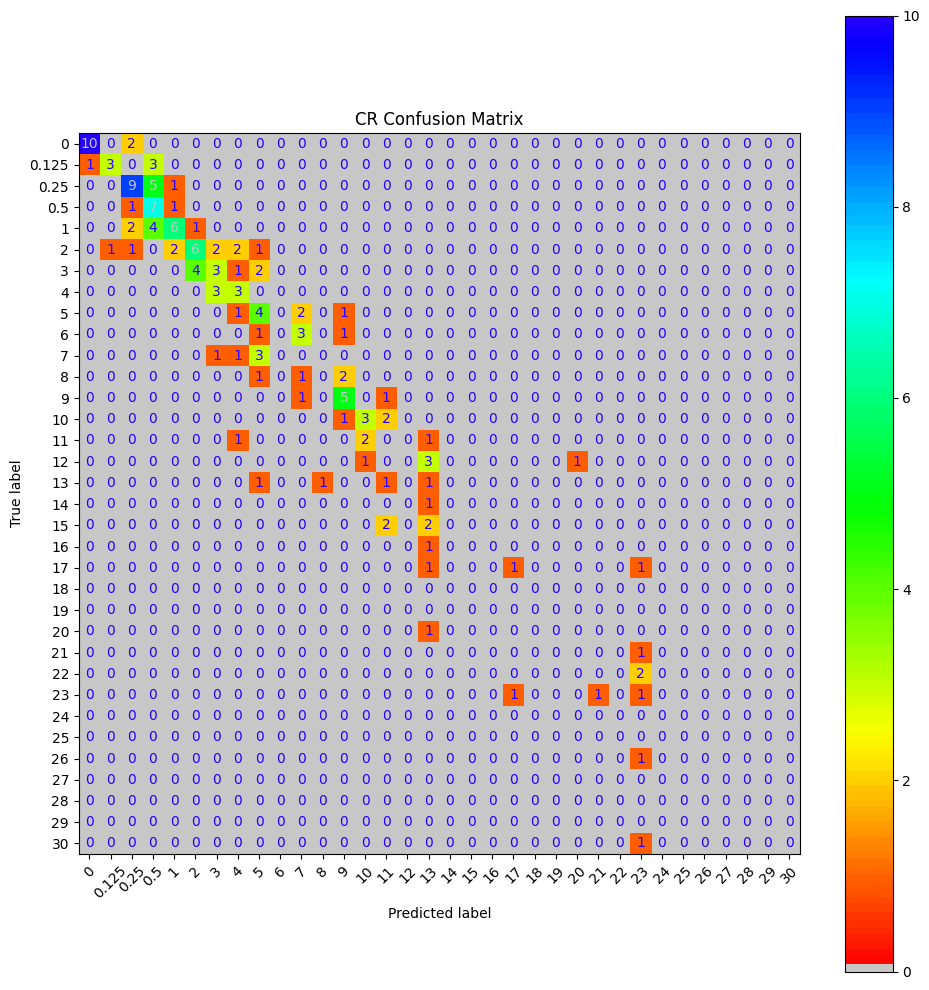

In [129]:
with torch.no_grad(): # we don't need gradients in the testing phase
    y_true = []
    y_pred = []
    cm = None
    for name,numeric,cat1,cat2,cat3,cat4,cat5,cat6,target in test_loader:

        # --- CRITICAL STEP: Move all input tensors to the GPU ---
        numeric = numeric.to(device)
        cat1 = cat1.to(device)
        cat2 = cat2.to(device)
        cat3 = cat3.to(device)
        cat4 = cat4.to(device)
        cat5 = cat5.to(device)
        cat6 = cat6.to(device)
        target = target.to(device)

        outputs = model(numeric,cat1,cat2,cat3,cat4,cat5,cat6)

        _, predictions = torch.max(outputs,1) # 1 is the dimension
        y_true = np.concatenate([y_true,target.cpu().numpy()])
        y_pred = np.concatenate([y_pred,predictions.cpu().numpy()])\

    
    # Calculate accuracy
    n_correct = (y_true == y_pred).sum().item()
    n_samples = y_true.shape[0]
    avg = 'macro'
    print(f'Accuracy:\t{accuracy_score(y_true,y_pred)*100:.2f}% ({n_correct}/{n_samples})')
    print(f'Recall:\t\t{recall_score(y_true,y_pred,average=avg)*100:.2f}%')
    print(f'Precision:\t{precision_score(y_true,y_pred,average=avg)*100:.2f}%')
    print(f'F1 Score:\t{f1_score(y_true,y_pred,average=avg)*100:.2f}%')

    # Create confusion matrix
    cm = confusion_matrix(y_true=y_true,y_pred=y_pred,labels=indices)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=crs)
    oldcolors = mpl.colormaps['hsv']
    newcolors = oldcolors(np.linspace(0,.70, 128))
    val = 200
    grey = np.array([val/256, val/256, val/256, 1])
    newcolors[:1, :] = grey
    cmap = ListedColormap(newcolors)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax,cmap=cmap)
    plt.xticks(rotation=45)
    plt.title("CR Confusion Matrix")
    plt.tight_layout()